In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Dec  3 22:21:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [3]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 512 kB 15.2 MB/s 


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

In [5]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    #有三类：0, 1(with_mask), 2(mask_weared_incorrect)
    if obj.find('name').text == "helmet":
        return 1
    elif obj.find('name').text == "head":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [6]:
%cd drive/MyDrive/kaggle/
imgs = list(sorted(os.listdir("./safety_helmet_detection/images/")))
labels = list(sorted(os.listdir("./safety_helmet_detection/annotations/")))

/content/drive/MyDrive/kaggle


In [7]:
class HelmetDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("./safety_helmet_detection/images/")))
        # self.labels = list(sorted(os.listdir("./safety_helmet_detection/annotations/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'hard_hat_workers'+ str(idx) + '.png'
        file_label = 'hard_hat_workers'+ str(idx) + '.xml'
        img_path = os.path.join("./safety_helmet_detection/images/", file_image)
        label_path = os.path.join("./safety_helmet_detection/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = HelmetDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=4, collate_fn=collate_fn)
examples = enumerate(data_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(batch_idx)
print(example_targets)

0
({'boxes': tensor([[357., 116., 404., 175.],
        [  4., 146.,  39., 184.],
        [253., 139., 275., 177.],
        [300., 145., 323., 181.],
        [116., 151., 138., 180.],
        [ 80., 151., 100., 180.],
        [ 62., 144.,  83., 172.],
        [322., 141., 345., 178.],
        [175., 156., 194., 186.],
        [222., 151., 240., 182.],
        [200., 146., 216., 173.],
        [ 98., 140., 112., 160.],
        [157., 150., 175., 177.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2]), 'image_id': tensor([0])}, {'boxes': tensor([[116., 230., 141., 252.],
        [ 99., 249., 126., 274.],
        [ 42., 212.,  70., 243.],
        [183., 237., 210., 263.],
        [204., 193., 227., 217.],
        [244., 109., 269., 137.],
        [275., 210., 303., 238.],
        [257., 173., 282., 196.],
        [243.,   0., 269.,  28.]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1]), 'image_id': tensor([1])}, {'boxes': tensor([[329., 216., 360., 245.],
        [298., 222., 32

In [9]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    # 加载经过预训练的模型
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    # 获取分类器的输入参数的数量in_features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    print("in_features:", in_features)
    # replace the pre-trained head with a new one
    # 用新的头部替换预先训练好的头部
    # 本实验的num_classes为3 
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

model = get_model_instance_segmentation(3)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

in_features: 1024


In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[357., 116., 404., 175.],
        [  4., 146.,  39., 184.],
        [253., 139., 275., 177.],
        [300., 145., 323., 181.],
        [116., 151., 138., 180.],
        [ 80., 151., 100., 180.],
        [ 62., 144.,  83., 172.],
        [322., 141., 345., 178.],
        [175., 156., 194., 186.],
        [222., 151., 240., 182.],
        [200., 146., 216., 173.],
        [ 98., 140., 112., 160.],
        [157., 150., 175., 177.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[116., 230., 141., 252.],
        [ 99., 249., 126., 274.],
        [ 42., 212.,  70., 243.],
        [183., 237., 210., 263.],
        [204., 193., 227., 217.],
        [244., 109., 269., 137.],
        [275., 210., 303., 238.],
        [257., 173., 282., 196.],
        [243.,   0., 269.,  28.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'image_id'

In [11]:
model.load_state_dict(torch.load('safety_helmet_detection/fasterrcnn_resnet50_fpn_20epochs.pt'))

<All keys matched successfully>

In [ ]:
num_epochs = 5
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)
training_loss = []

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        # loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())      

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss / len_dataloader)
    training_loss.append(epoch_loss / len_dataloader)

print(training_loss)

tensor(0.1852, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1751, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1971, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1799, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.1604, device='cuda:0', grad_fn=<DivBackward0>)
[tensor(0.1852, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.1751, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.1971, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.1799, device='cuda:0', grad_fn=<DivBackward0>), tensor(0.1604, device='cuda:0', grad_fn=<DivBackward0>)]


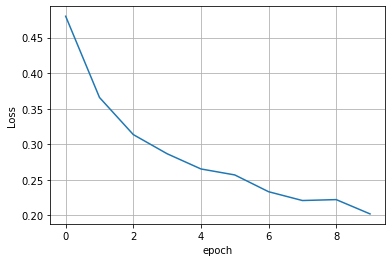

In [14]:
former_loss = [0.4800, 0.3658, 0.3136, 0.2867, 0.2654, 0.2570, 0.2334, 0.2210, 0.2223, 0.2022]
train_loss = [v.cpu().data for v in training_loss]
all_loss = former_loss + train_loss
fig1,ax1 = plt.subplots(1)
ax1.plot(range(0, 15), all_loss)
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
plt.grid()
plt.savefig('safety_helmet_detection/safety_helmet_train_loss.png')
plt.show()

In [15]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        print("1")
        break
print(annotations)

1
[{'boxes': tensor([[357., 116., 404., 175.],
        [  4., 146.,  39., 184.],
        [253., 139., 275., 177.],
        [300., 145., 323., 181.],
        [116., 151., 138., 180.],
        [ 80., 151., 100., 180.],
        [ 62., 144.,  83., 172.],
        [322., 141., 345., 178.],
        [175., 156., 194., 186.],
        [222., 151., 240., 182.],
        [200., 146., 216., 173.],
        [ 98., 140., 112., 160.],
        [157., 150., 175., 177.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[116., 230., 141., 252.],
        [ 99., 249., 126., 274.],
        [ 42., 212.,  70., 243.],
        [183., 237., 210., 263.],
        [204., 193., 227., 217.],
        [244., 109., 269., 137.],
        [275., 210., 303., 238.],
        [257., 173., 282., 196.],
        [243.,   0., 269.,  28.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'image_i

In [16]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[359.3775, 116.0410, 408.4114, 173.5733],
          [175.2875, 155.4357, 193.7583, 185.9515],
          [301.6761, 147.2440, 322.3986, 180.2534],
          [  5.7910, 144.2216,  36.5602, 183.0686],
          [ 97.5648, 139.6073, 112.1415, 160.3055],
          [ 61.0976, 142.2356,  82.0907, 171.9232],
          [253.4670, 141.1362, 276.4474, 175.4724],
          [ 79.6820, 153.3726,  99.7696, 177.2182],
          [199.8839, 147.0721, 216.2630, 171.5394],
          [159.4377, 149.9760, 176.8732, 176.5983],
          [119.4833, 150.1696, 139.8679, 178.8106],
          [223.6538, 151.3901, 241.7441, 177.2586],
          [321.8804, 140.8901, 343.0565, 177.4717],
          [253.8443, 142.5232, 274.6972, 177.5782],
          [ 27.8449, 204.4681,  49.3621, 232.1792],
          [ 96.8684, 138.6242, 113.6076, 161.5477],
          [320.8102, 141.5524, 343.5017, 177.5486],
          [223.1617, 151.6880, 242.6050, 176.3852],
          [ 20.1394, 142.5196,  40.8123, 182.2405],
   

In [17]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box.cpu().data

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

def plot_image_withColor(img_tensor, annotation, save_path=None):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for (box, label) in zip(annotation["boxes"],annotation["labels"]):
        xmin, ymin, xmax, ymax = box.cpu().data
        
        if(label == 1):
        # Create a Rectangle patch with different colors
        #red: with mask  green: mask_weared_incorrect  blue: without mask
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        elif(label == 2):
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
        else:
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
    
    if save_path:
      fig.savefig(save_path)
    plt.show()

In [18]:
print(preds[3])
print("------------------------------------")
print(annotations[3])

{'boxes': tensor([[199.3480, 148.9410, 228.9633, 188.5908],
        [ 48.3503, 157.3079,  64.1283, 172.4265],
        [185.9878, 184.9483, 201.2171, 206.5472],
        [ 49.5134, 155.7958,  63.0849, 171.7543],
        [171.9588,   0.0000, 188.5874,   6.7706]], device='cuda:0',
       grad_fn=<StackBackward0>), 'labels': tensor([1, 2, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9978, 0.8367, 0.5825, 0.1849, 0.0838], device='cuda:0',
       grad_fn=<IndexBackward0>)}
------------------------------------
{'boxes': tensor([[200., 151., 227., 185.],
        [ 49., 157.,  62., 168.],
        [186., 186., 200., 201.]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'image_id': tensor([3], device='cuda:0')}


Prediction


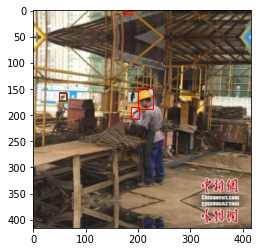

Target


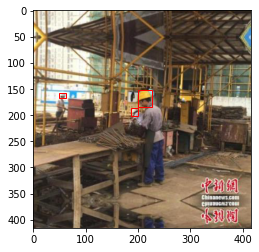

In [19]:
print("Prediction")
plot_image_withColor(imgs[3], preds[3], 'safety_helmet_detection/safety_helmet_eg1_pred.png')
print("Target")
plot_image_withColor(imgs[3], annotations[3], 'safety_helmet_detection/safety_helmet_eg1_label.png')

Prediction


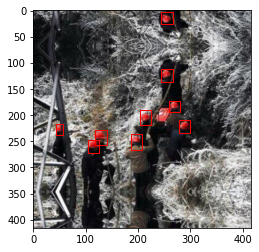

Target


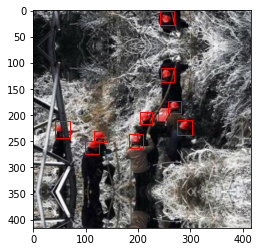

In [20]:
print("Prediction")
plot_image_withColor(imgs[1], preds[1], 'safety_helmet_detection/safety_helmet_eg2_pred.png')
print("Target")
plot_image_withColor(imgs[1], annotations[1], 'safety_helmet_detection/safety_helmet_eg2_label.png')

In [21]:
torch.save(model.state_dict(),'safety_helmet_detection/fasterrcnn_resnet50_fpn_20epochs.pt')

In [22]:
model2 = get_model_instance_segmentation(3)
model2.load_state_dict(torch.load('safety_helmet_detection/fasterrcnn_resnet50_fpn_20epochs.pt'))
model2.eval()
model2.to(device)

in_features: 1024


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [23]:
for i, (imgs, annotations) in enumerate(data_loader):
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        if i == 10:
          break
print(annotations)

[{'boxes': tensor([[122., 265., 131., 279.],
        [152., 282., 161., 292.],
        [142., 284., 151., 295.],
        [152., 400., 161., 410.],
        [142., 398., 151., 409.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'image_id': tensor([40], device='cuda:0')}, {'boxes': tensor([[241.,  68., 349., 183.],
        [241.,   0., 350.,  57.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([41], device='cuda:0')}, {'boxes': tensor([[278., 130., 344., 202.],
        [164., 154., 194., 191.],
        [ 73., 106., 147., 194.],
        [237., 156., 264., 185.],
        [149., 151., 167., 181.],
        [198., 156., 220., 182.],
        [ 73.,   0., 148.,  33.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 2, 2, 1], device='cuda:0'), 'image_id': tensor([42], device='cuda:0')}, {'boxes': tensor([[136., 130., 165., 169.],
        [359., 116., 399., 165.],
        [290., 142., 342., 204.],
        [200., 118., 232., 162.],
     

In [24]:
pred2 = model2(imgs)
metric = MeanAveragePrecision()
metric.update(pred2, annotations)
from pprint import pprint
pprint(metric.compute())

{'map': tensor(0.6877),
 'map_50': tensor(0.9896),
 'map_75': tensor(0.8915),
 'map_large': tensor(0.9000),
 'map_medium': tensor(0.7428),
 'map_per_class': tensor(-1.),
 'map_small': tensor(0.6208),
 'mar_1': tensor(0.2507),
 'mar_10': tensor(0.7338),
 'mar_100': tensor(0.7338),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.9000),
 'mar_medium': tensor(0.7563),
 'mar_small': tensor(0.6833)}


Predict with loaded model


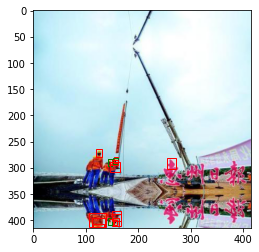

Target


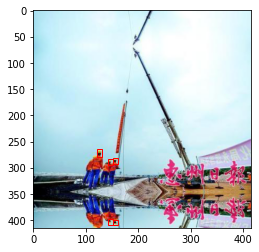

In [25]:
print("Predict with loaded model")
plot_image_withColor(imgs[0], pred2[0], 'safety_helmet_detection/safety_helmet_eg3_pred.png')
print("Target")
plot_image_withColor(imgs[0], annotations[0], 'safety_helmet_detection/safety_helmet_eg2_label.png')